# TPS 02-2022: Linear Classifiers

We test out several linear classifiers (mostly from `sklearn.linear_model`) with various preprocessing steps to see which give the best results on a small subset of the training data.

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 3

In [2]:
import numpy as np
import pandas as pd
import time
import math
import os
import pyarrow
import gc

# scikit-learn optimization
from sklearnex import patch_sklearn
patch_sklearn()

# Model evaluation
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score

# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Scoring Function

In [14]:
# Scoring/Training Baseline Function
def score_model(sklearn_model, preprocessing = None):
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, target_bins)):
        
        # Training and Validation Sets
        X_train, y_train = train[features].iloc[train_idx], train['target'].iloc[train_idx]
        X_valid, y_valid = train[features].iloc[valid_idx], train['target'].iloc[valid_idx]
        train_weight, valid_weight = train['sample_weight'].iloc[train_idx], train['sample_weight'].iloc[valid_idx]
    
        # Preprocessing
        start = time.time()
        if preprocessing:
            X_train = preprocessing.fit_transform(X_train)
            X_valid = preprocessing.transform(X_valid)
        
        # Create model
        model = clone(sklearn_model)
        try:
            model.fit(X_train, y_train, sample_weight = train_weight)
        except:
            model.fit(X_train, y_train)
        
        # validation
        valid_preds = model.predict(X_valid)
        scores[fold] = accuracy_score(y_valid, valid_preds, sample_weight = valid_weight)
        oof_preds[valid_idx] = valid_preds
        end = time.time()
        print(f'Fold {fold}: {round(scores[fold], 5)} accuracy in {round(end-start,2)}s.')
        times[fold] = end-start
        
    mask1, mask10 = train.gcd == 1, train.gcd == 10 
    mask1000, mask10000 = train.gcd == 1000, train.gcd == 10000
    print("\nAccuracy (1M Reads):", round(accuracy_score(oof_preds[mask1], train['target'].loc[mask1], sample_weight = train['sample_weight'].loc[mask1]), 5))
    print("Accuracy (100k Reads):", round(accuracy_score(oof_preds[mask10], train['target'].loc[mask10], sample_weight = train['sample_weight'].loc[mask10]), 5))
    print("Accuracy (1k Reads):", round(accuracy_score(oof_preds[mask1000], train['target'].loc[mask1000], sample_weight = train['sample_weight'].loc[mask1000]), 5))
    print("Accuracy (100 Reads):", round(accuracy_score(oof_preds[mask10000], train['target'].loc[mask10000], sample_weight = train['sample_weight'].loc[mask10000]), 5))
    print("Out-of-Fold Accuracy:", round(accuracy_score(oof_preds, train['target'], sample_weight = train['sample_weight']), 5))
    print(f'Training Time: {round(times.sum(), 2)}s')
    
    return oof_preds
    

# Confusion Matrix Plotting

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def plot_confusion_matrix(true_values, pred_values, gcds, plot_title = "Confusion Matrix"):
    
    gcd = [[1,10],[1000,10000]]
    
    # Confusion matrix
    fig, ax = plt.subplots(2, 2, figsize = (12,9))
    for row in range(2):
        for col in range(2):
            idx = 2*row + col
            cm = confusion_matrix(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]])
            np.fill_diagonal(cm, 0)
            disp = ConfusionMatrixDisplay(confusion_matrix = cm)
            disp.plot(ax = ax[row,col])
    plt.show()

# Load Data

In [5]:
%%time
from sklearn.preprocessing import LabelEncoder

train = pd.read_feather('../data/train.feather')
features = [x for x in train.columns if x not in ['row_id','target','sample_weight','gcd']]

encoder = LabelEncoder()
train['target'] = encoder.fit_transform(train['target'])
target_bins = train['target'].astype(str) + train['gcd'].astype(str)

print(f'Training Samples: {len(train)}')

Training Samples: 123993
CPU times: total: 1.11 s
Wall time: 192 ms


# 1. Logistic Regression

We test out several logistic regression pipelines involving different preprocessing steps such as feature scaling and PCA-based dimension reduction as well as regularization. 

From a grid search, we find that the ideal combination is are the parameters: `solver = 'sag'` with the `MinMaxScaler`. So, we will prefer the SAG solver but use SAGA solver if necessary (e.g. for testing L1 regularization).

In [6]:
# Model
from sklearn.linear_model import LogisticRegression

# Preprocessing 
from sklearn.preprocessing import MinMaxScaler

## 1.1 Baseline


Fold 0: 0.83401 accuracy in 127.87s.
Fold 1: 0.83448 accuracy in 128.03s.
Fold 2: 0.656 accuracy in 127.5s.

Accuracy (1M Reads): 0.85257
Accuracy (100k Reads): 0.86429
Accuracy (1k Reads): 0.76783
Accuracy (100 Reads): 0.61468
Out-of-Fold Accuracy: 0.77485
Training Time: 383.39s


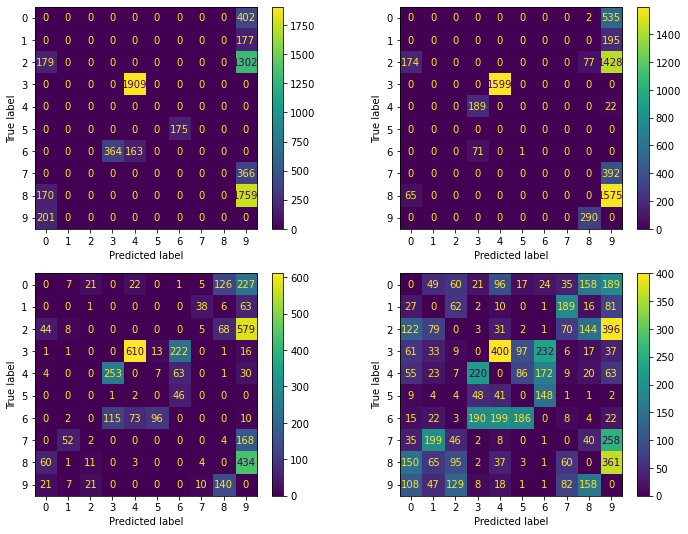

In [7]:
# Logistic Regression
oof_preds = score_model(
    LogisticRegression(
        penalty = 'none', 
        solver = 'saga', 
        n_jobs = -1,
        random_state = RANDOM_SEED,
    ),
    MinMaxScaler()
)

plot_confusion_matrix(train['target'],oof_preds, train['gcd'])

# 2. SGDClassifier

In [8]:
# Model
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler


Fold 0: 0.77368 accuracy in 104.57s.
Fold 1: 0.78019 accuracy in 113.07s.
Fold 2: 0.77582 accuracy in 107.66s.

Accuracy (1M Reads): 0.91325
Accuracy (100k Reads): 0.89672
Accuracy (1k Reads): 0.74164
Accuracy (100 Reads): 0.55464
Out-of-Fold Accuracy: 0.77656
Training Time: 325.3s


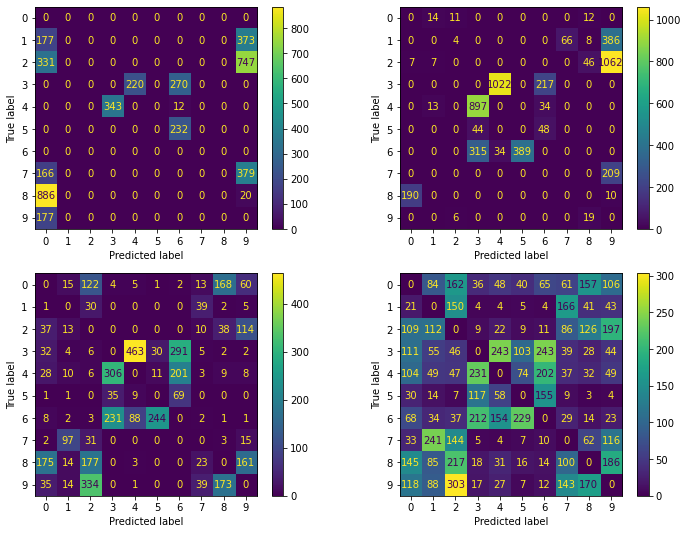

In [9]:
# None
oof_preds = score_model(
    SGDClassifier(
            penalty = None,
            n_jobs = -1,
            random_state = RANDOM_SEED,
    ),
    StandardScaler()
)

plot_confusion_matrix(train['target'],oof_preds, train['gcd'])

# 3. Linear SVC

The default `SGDClassifier` is very similar to `LinearSVC`, but we check it separately since it's likely to outperform it.

In [10]:
from sklearn.svm import SVC


Fold 0: 0.87185 accuracy in 73.05s.
Fold 1: 0.87287 accuracy in 79.76s.
Fold 2: 0.86681 accuracy in 72.83s.

Accuracy (1M Reads): 0.98767
Accuracy (100k Reads): 0.96934
Accuracy (1k Reads): 0.84588
Accuracy (100 Reads): 0.67913
Out-of-Fold Accuracy: 0.87051
Training Time: 225.64s


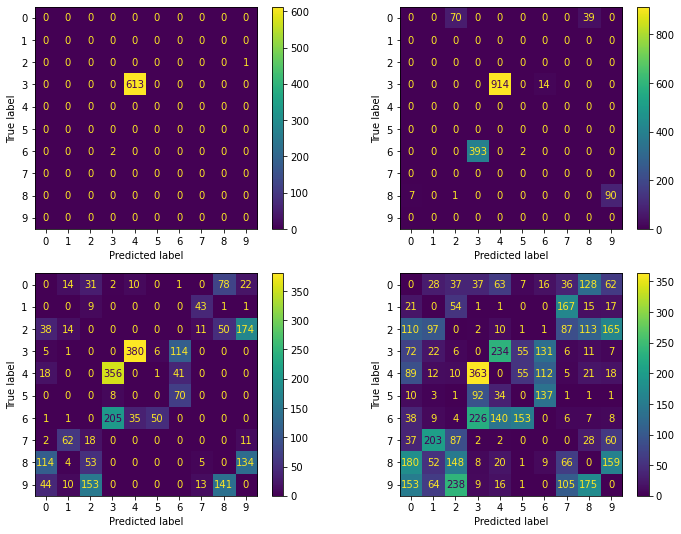

In [11]:
# Standard
oof_preds = score_model(
    SVC(
        kernel = 'linear',
        random_state = RANDOM_SEED,
    ),
    StandardScaler()
)

plot_confusion_matrix(train['target'],oof_preds, train['gcd'])

# Linear Discriminant Analysis

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 


Fold 0: 0.74696 accuracy in 3.65s.
Fold 1: 0.74406 accuracy in 3.67s.
Fold 2: 0.74572 accuracy in 3.54s.

Accuracy (1M Reads): 0.86279
Accuracy (100k Reads): 0.87974
Accuracy (1k Reads): 0.74789
Accuracy (100 Reads): 0.49179
Out-of-Fold Accuracy: 0.74558
Training Time: 10.86s


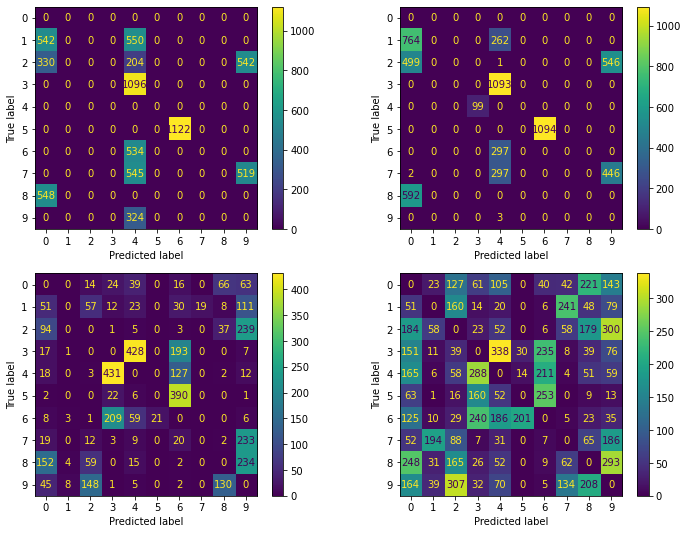

In [15]:
# Linear Discriminant Analysis
oof_preds = score_model(
    LinearDiscriminantAnalysis(),
    StandardScaler()
)

plot_confusion_matrix(train['target'],oof_preds, train['gcd'])


Fold 0: 0.62114 accuracy in 2.07s.
Fold 1: 0.63019 accuracy in 2.06s.
Fold 2: 0.63347 accuracy in 2.14s.

Accuracy (1M Reads): 0.58596
Accuracy (100k Reads): 0.58326
Accuracy (1k Reads): 0.62911
Accuracy (100 Reads): 0.71477
Out-of-Fold Accuracy: 0.62827
Training Time: 6.27s


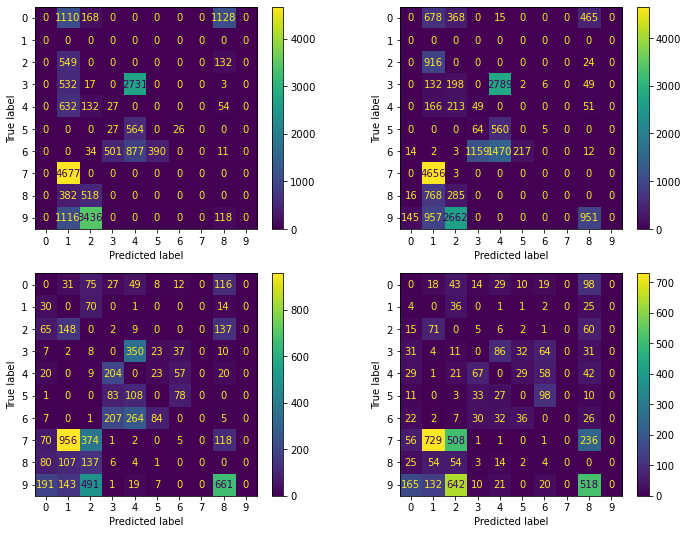

In [16]:
# Quadratic Discriminant Analysis
oof_preds = score_model(
    QuadraticDiscriminantAnalysis(),
    StandardScaler()
)

plot_confusion_matrix(train['target'],oof_preds, train['gcd'])